MDS
---
Multidimensional Scaling
* Replicatiion of https://link.springer.com/article/10.1007/s42113-020-00073-z
* Dateset: 120 Rock Images
* We have a ready prepared file with MDS coordinates
* And we have similarity judgements from which we could compute these MDS coordinates on our own

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from glob import glob

rock_images_glob = "120 Rock Images/*.png"
rock_images = glob(rock_images_glob)
rock_images.sort() # get them in the right order

judgements_glob = "Similarity Judgments Data/rocks_similarity_120_*.txt"
judgements_files = glob(judgements_glob)

mds_file = "MDS/mds_120_supplemental_dims.txt"

## A random rock

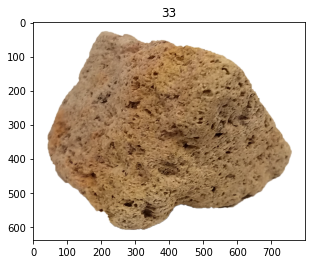

In [2]:
rock_id = 33
img = Image.open(rock_images[rock_id])
plt.imshow(img)
plt.title(rock_id);

## MDS coordinates

In [3]:
coords = np.loadtxt(mds_file, skiprows=1)
coords

array([[-0.72, -0.61, -0.19, ..., -1.8 , -4.5 , -5.  ],
       [ 0.3 ,  1.5 ,  1.01, ..., -2.5 , -3.  , -5.  ],
       [-0.55,  2.72, -0.24, ..., -2.55, -4.5 , -5.  ],
       ...,
       [ 0.65, -3.06,  1.93, ..., -1.05, -5.  , -2.  ],
       [-0.21, -1.53,  0.24, ..., -1.95, -5.  , -2.  ],
       [-0.78, -2.99, -0.99, ..., -0.6 , -5.  , -1.5 ]])

In [4]:
print("Number of rocks:     ", np.shape(coords)[0])
print("Number of dimensions:", np.shape(coords)[1])

Number of rocks:      120
Number of dimensions: 13


### Plotting rocks

In [5]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def imscatter(x, y, image, ax=None, zoom=1):
    """
    Creates scatter with image file
    """
    
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def plot_rocks(dim_a, dim_b, rock_images):
    """
    Plots rocks for give dimensions
    """
    plt.figure(figsize = (6, 6))
    for i, rock in enumerate(rock_images):
        imscatter(coords[i, dim_a-1], coords[i, dim_b-1], rock, zoom = 0.033)
    plt.xlabel(f"MDS Dimension {dim_a}")
    plt.ylabel(f"MDS Dimension {dim_b}")
    return None

### a) Dimensions 1 vs 2

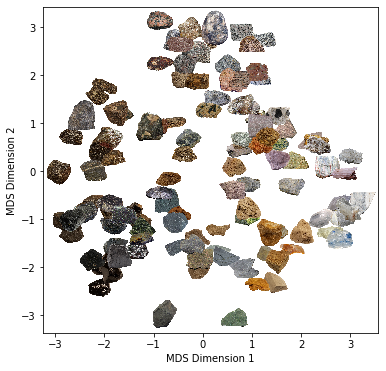

In [6]:
plot_rocks(1, 2, rock_images)

### b) Dimensions 3 vs 4

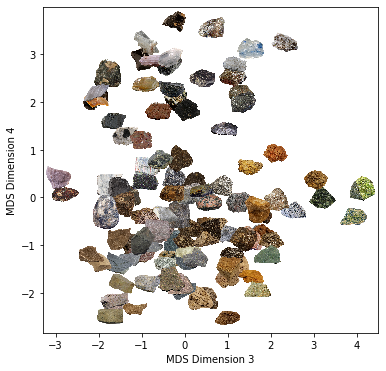

In [7]:
plot_rocks(3, 4, rock_images)

### c) Dimensions 5 vs 6

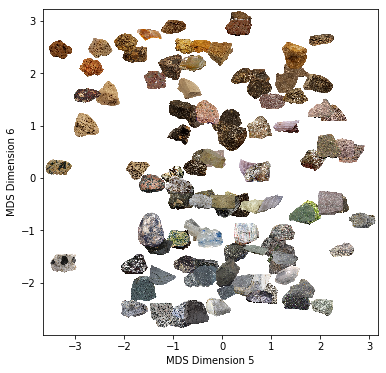

In [8]:
plot_rocks(5, 6, rock_images)

### d) Dimensions 7 vs 8

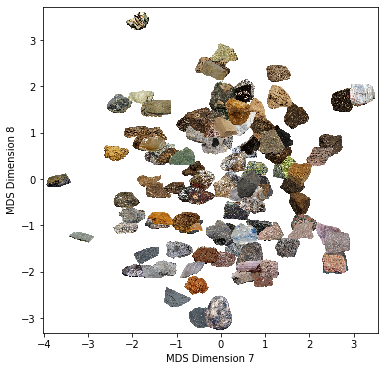

In [9]:
plot_rocks(7, 8, rock_images)

### e) Dimensions 8 vs 6

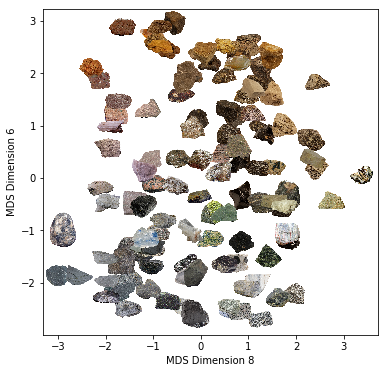

In [10]:
plot_rocks(8, 6, rock_images)

## Similarity judgements ...
... and creating the MDS coordinates by ourselves

In [11]:
len(judgements_files)

80